# An Introduction to Multistep Methods

**References:**

- Section 6.7 *Multistep Methods* of {cite}`Sauer`.
- Section 5.6 *Multistep Methods* of {cite}`Burden-Faires`.

## Introduction

When approximating derivatives we saw that there is a distinct advantage in accuracy to using the centered difference approximation

$$\frac{df}{dt}(t) \approx \delta_h f(t) := \frac{f(t+h) - f(t-h)}{2h}$$

(with error $O(h^2)$) over the forward difference approximation

$$\frac{df}{dt}(t) \approx \Delta_h f(t) := \frac{f(t+h) - f(t)}{h}$$

(which has error $O(h)$).

However Euler's method used the latter, and all ODE methods seen so far avoid using values at "previous" times like $t-h$.
There is a reason for this, as using data from previous times introduces some complications, but sometimes those are worth overcoming, so let us look into this.

In this section, we look at one simple multi-step method, based on the above centered-difference derivative approximation.

Future sections will look at higher order methods such as the Adams-Bashforth and Adams-Moulton methods.

## The Leapfrog method

Inserting the above centered difference approximation of the derivative into the ODE $du/dt = f(t, u)$ gives

$$\frac{u(t+h) - u(t-h)}{h} \approx f(t, u(t))$$

which leads to the **leapfrog method**

$$\frac{U_{i+1} - U_{i-1}}{2h} = f(t_i, U_i)$$

or

$$U_{i+1} = U_{i-1} + 2 h f(t_i, U_i)$$

This is the first example of a

```{prf:definition} Multistep Method
:label: multistep-method

A **multistep method** for numerical solution of an ODE IVP $du/dt = f(t, u)$, $u(t_0) = u_0$ is one of the form

$$ U_{i+1} = \phi(U_i, \dots U_{i-s+1}, h), \quad s > 1 $$

so that the new approximate value of $u(t)$ depends on approximate values at multiple previous times.

More specifically, this is called an $s$-step method.
```

This jargon is consistent with all methods seen in earlier sections being called *one-step methods*.
For example, Euler's method can be written as

$$ U_{i+1} = \phi_E(U_i, h) := U_i + h f(t_i, U_i) $$

and the explicit midpoint method can be written as the one-liner

$$ U_{i+1} = \phi_{EMP}(U_i, h) := U_i + h f(t_i+h/2, U_i + h f(t_i, U_i)/2) h $$

The leapfrog method already illustrates two of the complications that arise with multistep methods:

- The initial data $u(a) = u_0$ gives $U_0$, but then the above formula gives $U_1$ in terms of $U_0$ and the non-existent value $U_{-1}$; a different method is needed to get $U_1$.
More generally, with an $s$-step methods, one needs to compute the first $s-1$ steps, up to $U_{s-1}$, by some other method.

- leapfrog needs a constant step size $h$; the strategy of error estimation and error control using variable step size is still possible with some multistep methods, but that is distinctly more complicated than we have seen with one-step methods, and is not addressed in these notes.

Fortunately, many differential equations can be handled well by choosing a suitable fixed step size $h$.
Thus, in these notes we work only with equal step sizes, so that our times are $t_i = a + i h$ and we aim for approximations
$U_i \approx u(a + ih)$.

## Second order accuracy of the leapfrog method

Using the fact that the centered difference approximation is second order accurate,
one can verify that

$$\frac{u(t_{i+1}) - u(t_{i-1})}{2h} - f(t, u(t_i)) = O(h^2)$$

(Alternatively one can get this by inserting quadratic Taylor polynomials centered at $t_i$, and their error terms.)

The definition of local trunctation error needs to be extended slightly:
it is the error $U_{i+1} - u(t_{i+1})$ when one starts with exact values for all previous steps;
that is, assuming $U_j = u(t_j)$ for all $j\leq i$.

The above results then shows that the local truncation error in each step is $U_{i+1} - u(t_{i+1}) = O(h^3)$,
so that the "local truncation error per unit time" is

$$\frac{U_{i+1} - u(t_{i+1})}{h} = O(h^2)$$.

A theorem in the section on {doc}`ODE-IVP-3-error-results-one-step-methods`
says that when a one-step methods has local truncation error per unit time of $O(h^p)$ it also has global truncation error of the same order.
The situation is a bit more complicated with multi-step methods, but loosely:

**if** the errors in a multistep method has local truncation $O(h^p)$ **and** it converges
(i.e. the global error goes to zero at $h \to 0$) then it does so at the expected rate of $O(h^p)$.

But multi-step methods can fail to converge, even if the local truncation error is of high order!
This is dealt with via the concept of **stability**; not considered here, but addressed in both references above, and a topic for future expansion of these notes.

In particular, when the leapfrog method converges it is second order accurate, just like the centered difference approximation of $du/dt$ that it is built upon.

## The speed advantage of multi-step methods like the leapfrog method

This second order accuracy illustrates a major potential advantage of multi-step methods:
whereas any one-step Runge-Kutta method that is second order accurate (such as the explicit trapezoid or explicit midpoint methods) require at least two evaluations of $f(t, u)$ for each time step, the leapfrog methods requires only one.

More generally, for every $s$, there are $s$-step methods with errors $O(h^s)$ that require only one evaluation of $f(t, u)$ per time step — for example, the Adams-Bashforth methods, as seen at

- Section {doc}`ODE-IVP-7-multi-step-methods-Adams-Bashforth`
- https://en.wikipedia.org/wiki/Linear_multistep_method#Adams-Bashforth_methods
- https://en.m.wikiversity.org/wiki/Adams-Bashforth_and_Adams-Moulton_methods
- {cite}`Sauer` Section 6.7.1  and 6.7.2
- {cite}`Burden-Faires` Section 5.6

In comparison, any *explicit* one-step method order $p$ require at least $p$ evaluations of $f(t, u)$ per time step.

(See the {doc}`ODE-IVP-8-implicit-methods-Adams-Moulton` for the distinction between explicit and implicit methods.)

In [1]:
using PyPlot

In [2]:
include("NumericalMethods.jl")

Main.NumericalMethods

In [3]:
import .NumericalMethods as NM

In [4]:
function leapfrog(f, a, b, U_0, U_1, n)
    n_unknowns = length(U_0)
    t = range(a, b, n+1)
    u = zeros(n+1, n_unknowns)
    u[1,:] = U_0
    u[2,:] = U_1
    h = (b-a)/n
    for i in 2:n
        u[i+1,:] = u[i-1,:] + 2*h*f(t[i], u[i,:])
    end
    return (t, u)
end;

### Demo with the mass-spring system

As seen in the section {doc}`ODE-IVP-4-system-higher-order-equations`

the damped mass-spring equation is

$$
\begin{split}
M \frac{d^2 y}{d t^2} &= -K y - D \frac{d y}{d t}
\\
& \text{with initial conditions}
\\
y(a) &= y_0
\\
\left. \frac{dy}{dt} \right|_{t=a} &= v_0
\end{split}
$$

with first-order system form

$$
\begin{split}
\frac{d u_0}{d t} &= u_1
\\
\frac{d u_1}{d t} &= -\frac{K}{M} u_0 - \frac{D}{M} u_1
\\
&\text{with initial conditions}
\\
u_0(a) &= y_0
\\
u_1(a) &= v_0
\end{split}
$$

The right-hand side $f$ is given by

In [5]:
f_mass_spring(t, u) = [ u[2], -(K/M)*u[1] - (D/M)*u[2] ];

and the solutions seen in that section are given by function `y_mass_spring`

In [ ]:
function y_mass_spring(t; t_0, u_0, K, M, D)
    (y_0, v_0) = u_0
    discriminant = D^2 - 4K*M
    if discriminant < 0  # underdamped
        omega = sqrt(4K*M - D^2)/(2M)
        A = y_0
        B = (v_0 + y_0*D/(2M))/omega
        return exp(-D/(2M)*(t-t_0)) * ( A*cos(omega*(t-t_0)) + B*sin(omega*(t-t_0)))
    elseif discriminant > 0  # overdamped
        Delta = sqrt(discriminant)
        lambda_plus = (-D + Delta)/(2M)
        lambda_minus = (-D - Delta)/(2M)
        A = M*(v_0 - lambda_minus * y_0)/Delta
        B = y_0 - A
        return A*exp(lambda_plus*(t-t_0)) + B*exp(lambda_minus*(t-t_0))
    else
        lambda = -D/(2M)
        A = y_0
        B = v_0 - A * lambda
        return (A + B*t)*exp(lambda*(t-t_0))
    end
end;

which alternatively could be imported from module `NumericalMethods`.

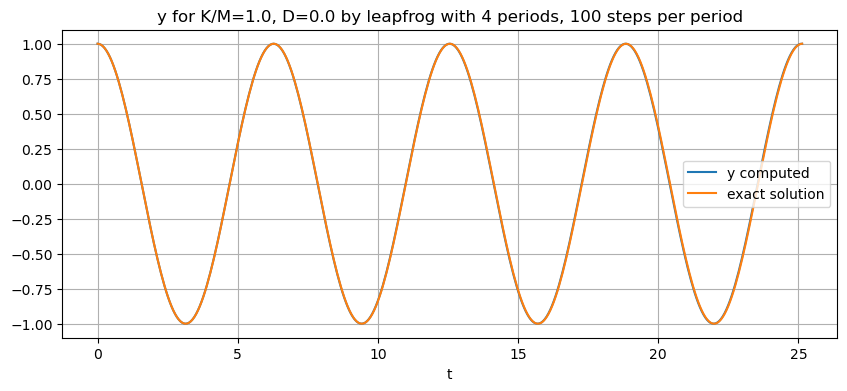

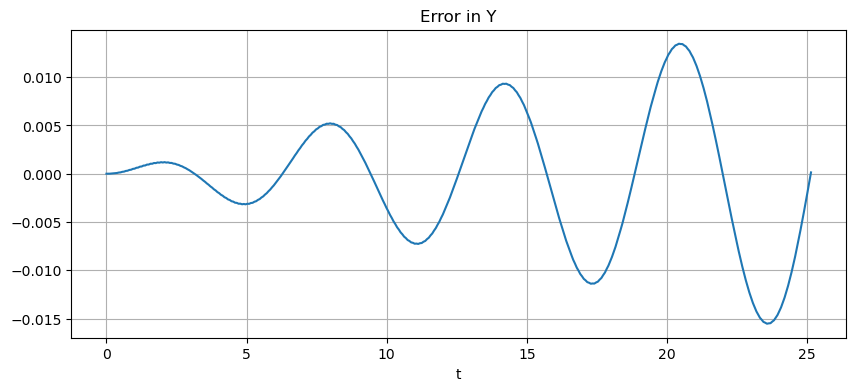

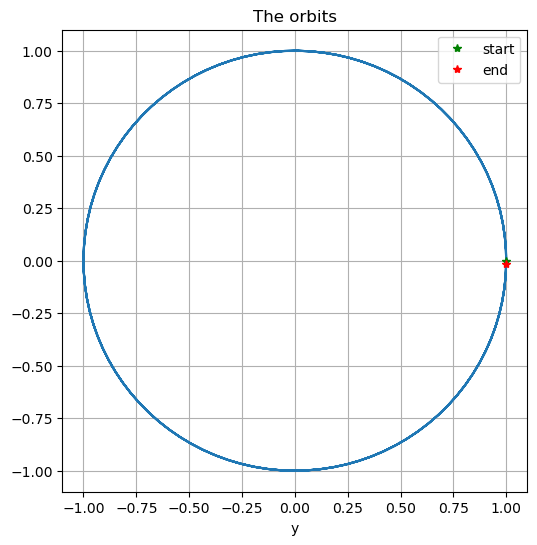

In [7]:
M = 1.0
K = 1.0
D = 0.0
U_0 = [1.0, 0.0]
a = 0.0
periods = 4
b = 2pi * periods

# Note: In the notes on systems, the second order methods were tested with 50 steps per period
#stepsperperiod = 50  # As for the second order accurate explicit trapezoid and midpoint methods
stepsperperiod = 100  # Equal cost per unit time as for the explicit trapezoid and midpoint and Runge-Kutta methods

n = Int(stepsperperiod * periods)

# We need U_1, and get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the time cost is negligible.
h = (b-a)/n
(t_1step, U_1step) = NM.rungekutta_system(f_mass_spring, a, a+h, U_0, 1)
U_1 = U_1step[end,:]
(t, U) = leapfrog(f_mass_spring, a, b, U_0, U_1, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("y for K/M=$(K/M), D=$D by leapfrog with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5,5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbits")
plot(Y, DY)
xlabel("y")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

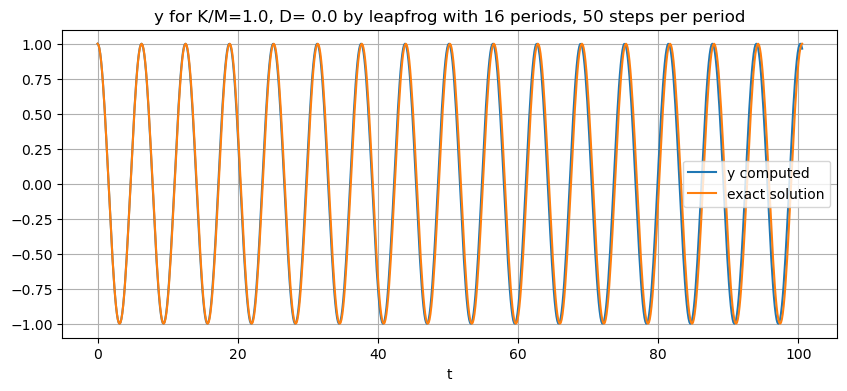

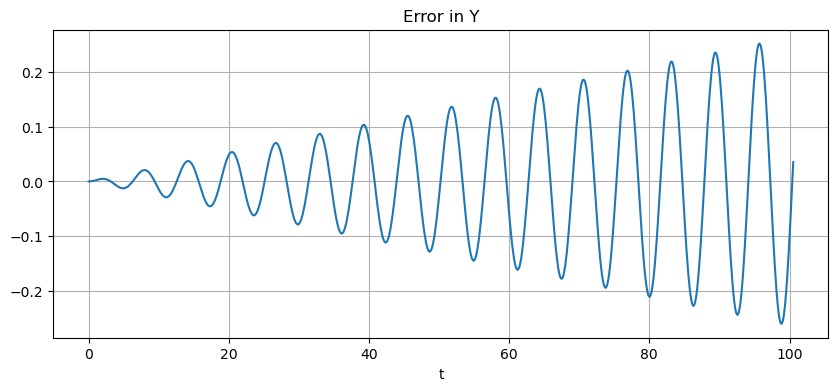

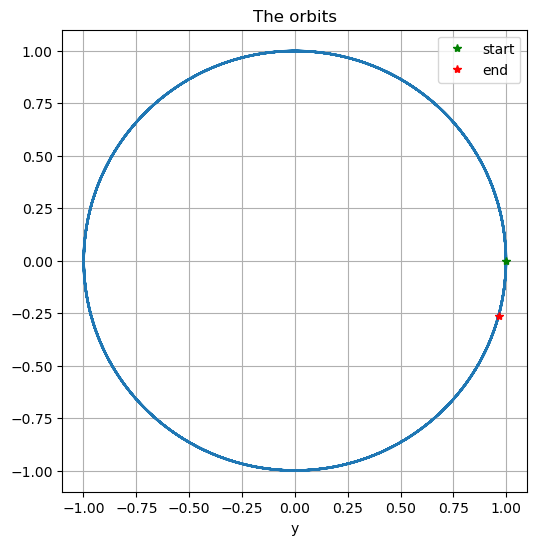

In [8]:
D = 0.0

periods = 16
b = 2pi * periods

# Note: In the notes on systems, the second order methods were tested with 50 steps per period
stepsperperiod = 50  # As for the second order accurate explicit trapezoid and midpoint methods
#stepsperperiod = 100  # Equal cost per unit time as for the explicit trapezoid and midpoint and Runge-Kutta methods
n = Int(stepsperperiod * periods)

# We need U_1, and get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the time cost is negligible.
h = (b-a)/n
(t_1step, U_1step) = NM.rungekutta_system(f_mass_spring, a, a+h, U_0, 1)
U_1 = U_1step[end,:]
(t, U) = leapfrog(f_mass_spring, a, b, U_0, U_1, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("y for K/M=$(K/M), D= $D by leapfrog with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5,5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbits")
plot(Y, DY)
xlabel("y")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

The errors in leapfrog have an interesting feature: they are largely in timing, with its solutions rotating a little too fast, while the orbits stay on the correct circle:
leapfrog respects the conserved "energy" $E(t) = \frac{1}{2}(y^2(t) + Dy^2(t))$.
In the section {doc}`ODE-IVP-7-multi-step-methods-Adams-Bashforth`, this behavior wil be compared to a more "typical" methods.

In some situations, this respecting of conserved quantities is very important, and the so-called **conservative methods** like leapfrog are then good choices.

### But with damping, things eventually go wrong!

This is an example in **instability**: reducing the step-size only postpones the problem, but does not avoid it.

In future sections it will be seen that the leapfrog method is stable (and a good choice) for "conservative" systems like the undamped mass-spring system, but unstable otherwise, such as for the damped case.

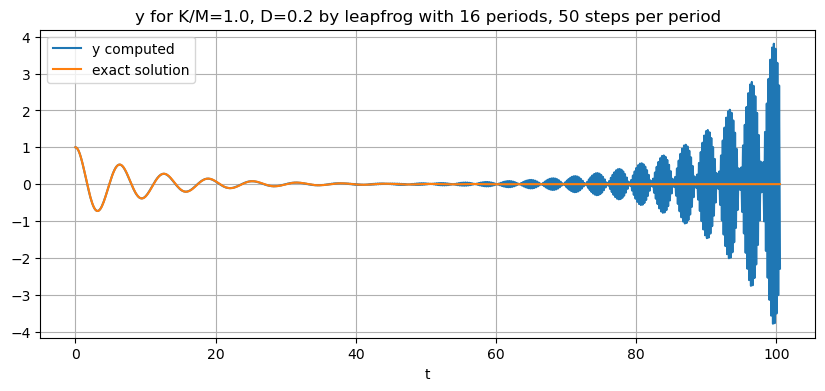

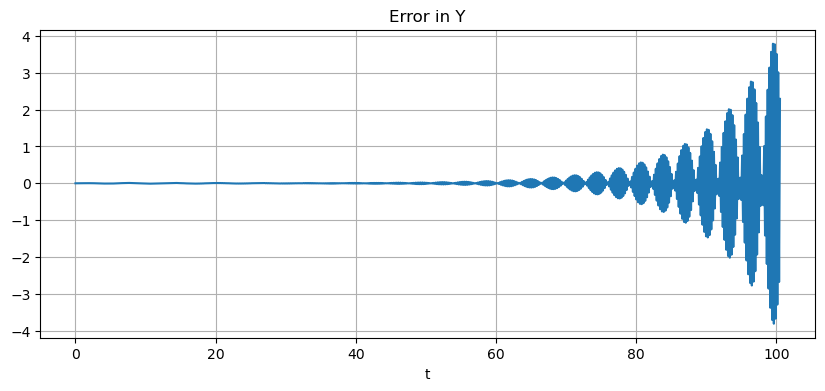

In [9]:
D = 0.2

periods = 16
b = 2pi * periods

# We need U_1, and get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the time cost is negligible.
h = (b-a)/n
(t_1step, U_1step) = NM.rungekutta_system(f_mass_spring, a, a+h, U_0, 1)
U_1 = U_1step[end,:]
(t, U) = leapfrog(f_mass_spring, a, b, U_0, U_1, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("y for K/M=$(K/M), D=$D by leapfrog with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)